### First of all importing the neccessary libraries to webscrap the dataset

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json
from time import sleep
import nest_asyncio
import asyncio
import aiohttp
import concurrent.futures

## Step 1: Obtaining 20 text classification and text generation models list

In [2]:
# Step 1: Obtain a list of the top-20 "Text Classification" models
classification_url = "https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads"
classification_models = []

response = requests.get(classification_url)
soup = BeautifulSoup(response.content, "html.parser")
model_list = soup.find_all("article", class_="overview-card-wrapper")
for model in model_list[:20]:
    model_name = model.find("header", class_="flex items-center mb-0.5").text.strip()
    model_details  = model.find("div", class_="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400").text.replace("\t","*").replace('\n', '*').replace('• ',"*").strip('').split("*")
    model_details =list(filter(bool, model_details))
    m_type= model_details[0]
    updated = model_details[2]
    downloaded= model_details[3]
    liked= model_details[4]
    dic = {
        "model_name": model_name,
        "model_type": m_type,
        "updated" : updated,
        "downloaded" : downloaded,
        "liked" : liked
    }
    # print(dic,end="\n")
    classification_models.append(dic)

In [3]:
# Obtain a list of the top-20 text generation models
generation_url = "https://huggingface.co/models?pipeline_tag=text-generation&sort=downloads"
generation_models = []

response = requests.get(generation_url)
soup = BeautifulSoup(response.content, "html.parser")
model_list = soup.find_all("article", class_="overview-card-wrapper")
for model in model_list[:20]:
    model_name = model.find("header", class_="flex items-center mb-0.5").text.strip()
    model_details  = model.find("div", class_="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400").text.replace("\t","*").replace('\n', '*').replace('• ',"*").strip('').split("*")
    model_details =list(filter(bool, model_details))
    m_type= model_details[0]
    updated = model_details[2]
    downloaded= model_details[3]
    liked= model_details[4]
    dic = {
        "model_name": model_name,
        "model_type": m_type,
        "updated" : updated,
        "downloaded" : downloaded,
        "liked" : liked
    }
    # print(dic,end="\n")
    generation_models.append(dic)

## creating a csv file from the data obtained from step 1

In [4]:

# creating a csv file for classification models and it's features

filename = 'classification_models.csv'  # Specify the filename for the CSV file
fieldnames = list(classification_models[0].keys())  # Specify the field names for the CSV file

with open(filename, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()  # Write the header row with field names
    writer.writerows(classification_models)  # Write the data rows to the CSV file

# creating a csv file for generative models and it's features
g_filename = 'generation_models.csv'  # Specify the filename for the CSV file
g_fieldnames = list(generation_models[0].keys())  # Specify the field names for the CSV file

with open(g_filename, 'w', newline='') as g_files:
    writer = csv.DictWriter(g_files, fieldnames=g_fieldnames)
    writer.writeheader()  # Write the header row with field names
    writer.writerows(generation_models)  # Write the data rows to the CSV file

### Step 2: Obtain and compare the number of ML apps ("spaces") for each "Text Classification" and "text generation" model

In [5]:
# function for finding the targeted element
def find_elements(html, parent_selector):
    soup = BeautifulSoup(html, 'html.parser')
    parent_tag = soup.select_one(parent_selector)
  
    temp={
    "linkedSpaces" : []
    }
    return parent_tag.get('data-props') if parent_tag is not None else json.dumps(temp)
  

In [12]:
nest_asyncio.apply()
# asynchronous network call to faster execution time and parallel task execution
async def fetch_linked_spaces(model_name, session):
    model_url = f"https://huggingface.co/{model_name['model_name']}"
    async with session.get(model_url) as response:
        data = []
        if response.status == 200:
            content = await response.text()
            soup = BeautifulSoup(content, "html.parser")
            linked_spaces = soup.find_all(attrs={"data-target": "LinkedSpacesList"})
            # print(linked_spaces)
            if linked_spaces:
                data = [item['id'] for item in json.loads(linked_spaces[0].get('data-props'))['linkedSpaces']]
                
        return {
            "model_name": model_name['model_name'],
            "model_url": model_url,
            "space_list": data,
            "total_app": len(data)
        }

async def get_app_count(models):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_linked_spaces(model_name, session) for model_name in models]
        app_count = await asyncio.gather(*tasks)
    return app_count

async def main():
    class_app_count = await get_app_count(classification_models)
    gen_app_count = await get_app_count(generation_models)
    return class_app_count,gen_app_count

loop = asyncio.get_event_loop()
classification_app_count,generation_app_count = loop.run_until_complete(main())
# print(app_counts)

In [21]:
#creating csv fuke fir classification_app_count
# Specify the CSV file path
csv_file = 'classification_app_count.csv'

# Extract the keys from the first object to use as column headers
keys = classification_app_count[0].keys()

# Write JSON data to CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(classification_app_count)

#creating csv fuke fir generation_app_count
# Specify the CSV file path
csv_file = 'generation_app_count.csv'

# Extract the keys from the first object to use as column headers
keys = generation_app_count[0].keys()

# Write JSON data to CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(generation_app_count)

### Step 3 :obtain and compare the source code size of the ML apps ("spaces") obtained in step 2 (HINT: check the "Files" tab at the top-right of a given space's page)

In [22]:
# converting kb to bytes to store size in bytes
def kb_to_bytes(kb):
    s_bytes = kb * 1024
    return s_bytes

In [24]:
# asynchronous network call to faster execution time and parallel task execution
async def fetch_code_size(session, space):
    space_url = f"https://huggingface.co/spaces/{space}/tree/main"
    async with session.get(space_url) as response:
        space_soup = BeautifulSoup(await response.text(), "html.parser")
        file_download_selector = '[title="Download file"]'
        available_files = space_soup.select(file_download_selector)
        code_size = sum(float(file.text.split(" ")[0]) if file.text.split(" ")[1].strip() != "kB" else kb_to_bytes(float(file.text.split(" ")[0])) for file in available_files)
    return {"app_name": space, "size": code_size}

async def get_app_source_size(app_count):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_code_size(session, space) for x in app_count for space in x["space_list"]]
        app_source_size = await asyncio.gather(*tasks)
    return app_source_size


async def main():
    class_app_sizes= await get_app_source_size(classification_app_count)
    gen_app_sizes = await get_app_source_size(generation_app_count)
    return class_app_sizes,gen_app_sizes

loop = asyncio.get_event_loop()
class_app_source_sizes,gen_app_source_sizes=loop.run_until_complete(main())

In [26]:
# create csv for class_app_source_sizes
# Specify the CSV file path
csv_file = 'class_app_source_sizes.csv'
csv_file1 = 'gen_app_source_sizes.csv'

# Extract the keys from the first object to use as column headers
keys = class_app_source_sizes[0].keys()
keys1=gen_app_source_sizes[0].keys()

# Write JSON data to CSV file
with open(csv_file, 'w', newline='') as file, open(csv_file1,'w',newline='') as file1:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(class_app_source_sizes)
    
    writer = csv.DictWriter(file1, fieldnames=keys)
    writer.writeheader()
    writer.writerows(gen_app_source_sizes)

### starting ploting 

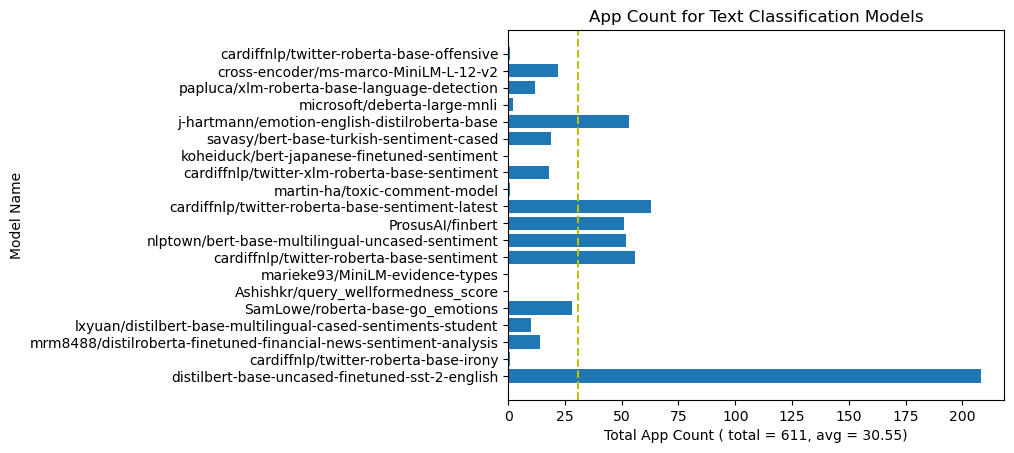

In [51]:
all_model_names = [item['model_name'] for item in classification_app_count]
total_apps = [item['total_app'] for item in classification_app_count]

plt.barh(all_model_names, total_apps)

average = sum(total_apps) / len(total_apps)
plt.axvline(average, color='y', linestyle='--', label='Average')

plt.ylabel('Model Name')
plt.xlabel(f'Total App Count ( total = {sum(total_apps)}, avg = {average})')
plt.title('App Count for Text Classification Models')
plt.show()


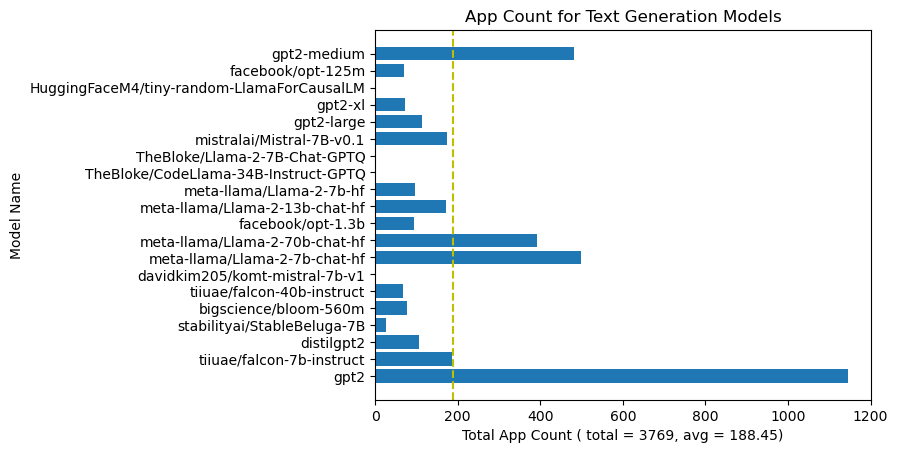

In [52]:
all_model_names = [item['model_name'] for item in generation_app_count]
total_apps = [item['total_app'] for item in generation_app_count]

plt.barh(all_model_names, total_apps)

average = sum(total_apps) / len(total_apps)
plt.axvline(average, color='y', linestyle='--', label='Average')

plt.ylabel('Model Name')
plt.xlabel(f'Total App Count ( total = {sum(total_apps)}, avg = {average})')
plt.title('App Count for Text Generation Models')
plt.show()

### Here clearly we can see that Total app count and average app count is much greater in text generaton models